In [1]:
%matplotlib inline


In [2]:
import os
import torch
import copy
from geom3d import train_models
from geom3d.train_models import Pymodel
from geom3d.train_models import read_config, load_data, train_val_test_split, model_setup
import importlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [3]:
def test_model(chkpt_path, config_dir, cluster):
    config = read_config(config_dir)
    np.random.seed(config["seed"])
    torch.cuda.manual_seed_all(config["seed"])
    torch.manual_seed(config["seed"])
    config["device"] = "cuda:0" if torch.cuda.is_available() else "cpu"
    config['test_set_fragment_cluster'] = cluster


    print('checkpoint used:', chkpt_path)
    checkpoint = torch.load(chkpt_path)
    model, graph_pred_linear = model_setup(config)
    print("Model loaded: ", config["model_name"])

    # Pass the model and graph_pred_linear to the Pymodel constructor
    pymodel = Pymodel(model, graph_pred_linear, config)
    # Load the state dictionary
    pymodel.load_state_dict(state_dict=checkpoint['state_dict'])
    # Set the model to evaluation mode
    pymodel.eval()

    dataset = load_data(config)
    np.random.seed(config["seed"])
    torch.cuda.manual_seed_all(config["seed"])
    pymodel = pymodel.to(config["device"])

    train_loader, val_loader, test_loader = train_val_test_split(
        dataset, config=config, batch_size=config["batch_size"]
    )

    print("pymodel device", pymodel.device)
    print("Target: ", config["target_name"])

    y_true = []
    y_pred = []
    InChIKey = []
    for x in test_loader:
        with torch.no_grad():
            Y_pred = pymodel(x.to(config["device"]))
        y_true.append(x.y.to('cpu').numpy())
        y_pred.append(Y_pred.to('cpu').detach().numpy().flatten())
        # retrieve InChIKey of the test set
        InChIKey.append(x.InChIKey)

    # Flatten the lists
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    InChIKey = [item for sublist in InChIKey for item in sublist]

    return y_true, y_pred, InChIKey


In [4]:
import os
import pandas as pd

model_names = ['DimeNet']
clusters = [1,2,3,4,5,6]  # Update to include all clusters if needed
target = 'ES1'

# Initialize a dictionary to store dataframes for each cluster
cluster_dfs = {}

# Loop over clusters
for cluster in clusters:
    # Initialize an empty dataframe for the current cluster
    df_cluster = pd.DataFrame()

    # Loop over model names
    for model_name in model_names:
        # Check if csv file already exists
        csv_path = f'/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment/{cluster}_cluster_{target}_model_inferences.csv'
        if os.path.exists(csv_path):
            print(f'{cluster}_cluster_{target}_model_inferences.csv already exists')
            # Load the existing dataframe
            df = pd.read_csv(csv_path, index_col=0)
        else:
            print(f'{cluster}_cluster_{target}_model_inferences.csv does not exist')
            # Create an empty dataframe
            df = pd.DataFrame()

        config_dir = f"/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment/{target}_experiment/{model_name}_opt_{target}_80000_{cluster}"
        
        # Find the checkpoint path
        for file in os.listdir(config_dir):
            if file.endswith(".ckpt"):
                chkpt_path = os.path.join(config_dir, file)
                break  # Break after finding the first checkpoint file

        if os.path.exists(chkpt_path):
            # Test the model (assuming this part of the code is provided elsewhere)
            y_true, y_pred, InChIKey = test_model(chkpt_path, config_dir, cluster)

            # Create a DataFrame with the y_true and y_pred values, and the InChIKey as the index
            df_temp = pd.DataFrame({model_name + f'_true_{target}': y_true, 
                                    model_name + f'_pred_{target}': y_pred}, 
                                    index=InChIKey)
            
            # Concatenate the dataframes while aligning with the existing index
            df = pd.concat([df, df_temp], axis=1)
            
            # Save the DataFrame to a CSV file
            df.to_csv(csv_path)
            print(f'{cluster}_cluster_{target}_model_inferences.csv saved')
            
            # Append the current dataframe to the cluster dataframe
            df_cluster = pd.concat([df_cluster, df_temp], axis=1)
        else:
            print(f'Checkpoint file {chkpt_path} does not exist')
    
    # Store the cluster dataframe in the dictionary
    cluster_dfs[cluster] = df_cluster

# Example of accessing a dataframe for a specific cluster
print(cluster_dfs[clusters[0]]) 


1_cluster_ES1_model_inferences.csv already exists
config loaded from /rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment/ES1_experiment/DimeNet_opt_ES1_80000_1
checkpoint used: /rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment/ES1_experiment/DimeNet_opt_ES1_80000_1/epoch=18-val_loss=0.15-other_metric=0.00.ckpt
Model loaded:  DimeNet
/rds/general/user/cb1319/home/GEOM3D/Geom3D/datasets/80000dataset_ES1.pt
Loading dataset split indices from /rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment/datasplit_80000_fragment_scaffold_threshold_0.067_cluster_1.npz
train_idx:  [24588 46008 47844 ... 74040 12568 48769]
valid_idx:  [24527 78484  8984 ... 63603  1446 26330]
test_idx:  [    4     7     8 ... 79990 79995 79996]
Number of training samples: 42684
Number of validation samples: 5336
Number of test samples: 31980
pymodel device cuda:0
Target:  ES1
1_cluster_ES1_model_inferences.csv saved
2_cluster_ES1_model_inferences.csv already exists
config loaded fro

In [5]:
df = pd.read_csv('/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment/5_cluster_ES1_model_inferences.csv', index_col=0)
df


,PaiNN_true_ES1,PaiNN_pred_ES1,SchNet_true_ES1,SchNet_pred_ES1,Equiformer_true_ES1,Equiformer_pred_ES1,SphereNet_true_ES1,SphereNet_pred_ES1,DimeNetPlusPlus_true_ES1,DimeNetPlusPlus_pred_ES1,DimeNet_true_ES1,DimeNet_pred_ES1
GXMHUFGMOCZPHO-CLHYIUPASA-N,3.575,2.794475,3.575,2.794139,3.575,2.427154,3.575,2.825947,3.575,2.444159,3.575,3.023100
ZBBFBVMXCQEWSC-UHFFFAOYSA-N,2.774,2.778273,2.774,2.790372,2.774,2.615985,2.774,2.824596,2.774,2.385305,2.774,2.948804
XODWIAOKFBVISC-UHFFFAOYSA-N,2.721,2.786647,2.721,2.807992,2.721,2.047087,2.721,2.824554,2.721,1.826218,2.721,2.813560
HQTJKUINLAROAE-PHEFMCIRSA-N,2.655,2.773672,2.655,2.785711,2.655,2.352103,2.655,2.824442,2.655,2.366249,2.655,2.819723
DVVVFUJTMVEJGX-UHFFFAOYSA-N,2.365,2.763480,2.365,2.771449,2.365,2.314933,2.365,2.826119,2.365,2.263853,2.365,2.941310
...,...,...,...,...,...,...,...,...,...,...,...,...
KYJHNSLYNUEULW-SVPAYZKRSA-N,2.782,2.770646,2.782,2.783494,2.782,2.276093,2.782,2.825159,2.782,2.253963,2.782,3.035184
ZCJCZKGBIADWHQ-UHFFFAOYSA-N,2.892,2.766227,2.892,2.798600,2.892,2.338334,2.892,2.824537,2.892,2.219793,2.892,2.802945
WTNRRYRGLZHBLM-PHHJNFGPSA-N,2.869,2.778507,2.869,2.793054,2.869,2.503430,2.869,2.824466,2.869,2.578144,2.869,3.033736
MXTMMFDIORWOMC-UHFFFAOYSA-N,2.682,2.768504,2.682,2.791499,2.682,2.238100,2.682,2.824661,2.682,2.050624,2.682,2.891158


In [6]:
from geom3d.utils.fragment_scaffold_split import *

from geom3d.train_models import *
import torch
import copy

from geom3d.utils import fragment_scaffold_split
from geom3d.utils import database_utils


import os
os.chdir('/rds/general/user/cb1319/home/GEOM3D/Geom3D/')
config_dir = os.getcwd()+"/fragment_experiment/SchNet_opt_combined_80000"
config = read_config(config_dir)

dataset_path = "/rds/general/user/cb1319/home/GEOM3D/Geom3D/datasets/80000dataset_combined.pt"
dataset = torch.load(dataset_path)

threshold = 0.067

config loaded from /rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment/SchNet_opt_combined_80000


In [7]:
import pandas as pd
import os

# Define the paths where the model predictions are stored
base_path = "/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment/"
model_names = ['Equiformer', 'SphereNet', 'DimeNetPlusPlus']  # Add more model names if needed
num_models = len(model_names)

# Define the list of fragments
df_total, df_precursors, X_frag_mol, X_InChIKey = load_dataset(dataset, config)
fragments = X_InChIKey  # Insert your list of fragments here

# Load morgan_keys dictionary or use the function cluster_analysis(dataset, config, threshold) to obtain it
morgan_keys_1 = cluster_analysis(dataset, config, threshold)


clustering done with metric: rogerstanimoto
Index(['InChIKey', 'Morgan_Fingerprint'], dtype='object')
Clustering dataset with threshold 0.067
Number of clusters: 10
Number of molecules in each cluster for morgan fp: {1: 99, 2: 51, 3: 7, 4: 29, 5: 27, 6: 3, 7: 60, 8: 19, 9: 8, 10: 7}
Number of molecules in each cluster after merging small clusters: {1: 99, 2: 51, 3: 36, 4: 30, 5: 60, 6: 34}


In [9]:
morgan_keys = pd.read_csv('/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment/fragment_exp_results.csv', index_col=0)

In [ ]:
# go through the InChIKeys in the morgan keys dataframe (InChIKeys column) only for thie first row
# for each fragment, find the oligomers in df_total and add them to the morgan_keys dataframe
for k in range(morgan_keys['InChIKey'].shape[0]):
    print(morgan_keys['InChIKey'][k])
    oligomers = []
    # find the row in df_total that corresponds to this fragment
    for j in range(df_total.shape[0]):
        inchi_key = []
        for i in range(6):
            col_name = f'InChIKey_{i}'
            if str(df_total[col_name][j]) == str(morgan_keys['InChIKey'][k]):
                # find the InChIKey for this row in df_total
                inchi_key = df_total['InChIKey'][j]
                # add the InChIKey to the oligomers list if it is not already there
                if inchi_key not in oligomers:
                    oligomers.append(inchi_key)
    print('amount of oligomers:', len(oligomers))
    # add the oligomers to the morgan_keys dataframe for this fragment
    morgan_keys['oligomers'][k] = oligomers

In [10]:
morgan_keys

,InChIKey,Morgan_Fingerprint,Cluster,oligomers,mean_diff_SchNet_ES1,mean_diff_PaiNN_ES1,mean_diff_Equiformer_ES1,mean_diff_SphereNet_ES1,mean_diff_DimeNetPlusPlus_ES1
0,ULRLMMWHCRPTDR-UHFFFAOYSA-N,[0 0 0 ... 0 0 0],4,"['IUZAERGSYNJRJJ-NUYXUUSISA-N', 'MDNDOEHLLBTOI...",0.324040,0.304281,0.303768,0.303868,2.154598
1,KYORXLIHDAZXPK-UHFFFAOYSA-N,[0 0 0 ... 0 0 0],2,"['IUZAERGSYNJRJJ-NUYXUUSISA-N', 'MDNDOEHLLBTOI...",0.304581,0.304923,0.304553,0.304416,0.304874
2,AMGZARGPNNDZNG-UHFFFAOYSA-N,[0 0 0 ... 0 0 0],5,"['HEARLZDLHXVYEJ-UHFFFAOYSA-N', 'BBWANVAHXIOZB...",0.303144,0.306447,0.727036,0.303278,0.784065
3,UVCFYBOLMFIWGF-FPYGCLRLSA-N,[0 0 0 ... 0 0 0],1,"['JJLVYFYFQNBEPY-JUNKXYSISA-N', 'VVWMKADWJPSIL...",0.304194,0.304245,0.304320,0.304284,0.330131
4,PQZAHLJJGPAGBD-OQFOIZHKSA-N,[0 0 0 ... 0 0 0],1,"['OYGIDKAKALBMDL-VJPAUINSSA-N', 'FKKKGDACYNPSN...",0.298122,0.298321,0.297911,0.297838,0.321497
...,...,...,...,...,...,...,...,...,...
305,MRBCQJMEGDDUNN-WMZJFQQLSA-N,[0 0 0 ... 0 0 0],1,"['BUYIPFHCRXLLKO-NGBFVLQYSA-N', 'ASUNKKFGBUGJD...",0.301969,0.302081,0.301979,0.302009,0.318881
306,ITWOUVVCPPUABP-WCIBSUBMSA-N,[0 0 0 ... 0 0 0],1,"['YILMCWVCYPDZNU-FIOTWBICSA-N', 'HAPAQKWTZISQT...",0.318945,0.318570,0.318971,0.318997,0.332417
307,BNVUEFDNDBLDLM-UHFFFAOYSA-N,[0 0 0 ... 0 0 0],5,"['YPBBWLNISCCUDI-UHFFFAOYSA-N', 'CNMWQARVRVTCT...",0.296363,0.297660,0.478736,0.293713,0.492719
308,BBVSASGXSWONDF-UHFFFAOYSA-N,[0 0 0 ... 0 0 0],2,"['DYRLUSMMLOETPR-UHFFFAOYSA-N', 'DQLGSTVGFAFGC...",0.307063,0.306540,0.306873,0.308023,0.306805


In [12]:
# for each row in the morgan keys dataframe, find the cluster number in the 'Cluster' column
# for the specific cluster, access the {cluster}_cluster_ES1_model_inferences.csv file
# for each InChIKey in the oligomers column, find the row in the {cluster}_cluster_ES1_model_inferences.csv file
# for each model, find the true and pred columns, take the absolute difference for each oligomer and find the mean of the differences for each model
# add the mean differences to the morgan_keys dataframe in a new column called 'mean_diff_{model_name}_ES1'

import pandas as pd
import os
import ast

# Assuming you have a list of model names
model_names = ['DimeNet']  # Update with your actual model names

# Assuming you have a list of cluster numbers
cluster_numbers = [1, 2, 3, 4, 5, 6]  # Update with your actual cluster numbers

target = 'ES1'

# Assuming your morgan_keys dataframe is already populated with oligomers
# and has a 'Cluster' column containing the cluster numbers

for k in range(morgan_keys.shape[0]):
    # Get the cluster number for the current fragment
    cluster = morgan_keys['Cluster'][k]
    
    # Load the dataframe for the current cluster
    df_cluster = pd.read_csv(f'/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment/{cluster}_cluster_{target}_model_inferences.csv', index_col=0)

    # Initialize an empty list to store the mean differences for each model
    mean_diffs = []
    
    # Loop over model names
    for model_name in model_names:
        print(model_name)
        # Initialize an empty list to store the differences for the current model
        diffs = []
        # Loop over oligomers, by looking at the list of oligomers for the current fragment in the morgan_keys dataframe, the list has the oligomer names separated by commas
        for oligomer in ast.literal_eval(morgan_keys['oligomers'][k]):
            # Find the row in the dataframe for the current oligomer if it exists
            if oligomer not in df_cluster.index:
                continue
            
            row = df_cluster.loc[oligomer]

            # Calculate the absolute difference between the true and pred columns
            diff = abs(row[model_name + f'_true_{target}'] - row[model_name + f'_pred_{target}'])
            
            # Append the difference to the list
            diffs.append(diff)
        
        # Calculate the mean difference for the current model
        print(len(diffs), len(ast.literal_eval(morgan_keys['oligomers'][k])))
        mean_diff = sum(diffs) / len(diffs)
        
        # Append the mean difference to the list
        mean_diffs.append(mean_diff)
    
    # Add the mean differences to the morgan_keys dataframe for the current fragment
    for i, model_name in enumerate(model_names):
        col_name = f'mean_diff_{model_name}_{target}'
        if col_name not in morgan_keys.columns:
            morgan_keys[col_name] = None  # Create the column if it doesn't exist
        
        # Assign the mean differences to the corresponding column and row
        morgan_keys.loc[k, col_name] = mean_diffs[i]




DimeNet
5425 5576
DimeNet
9997 10254
DimeNet
8680 8927
DimeNet
1698 1743
DimeNet
3251 3335
DimeNet
5669 5826
DimeNet
3225 3297
DimeNet
8031 8242
DimeNet
529 542
DimeNet
305 313
DimeNet
21772 22405
DimeNet
7998 8209
DimeNet
6094 6261
DimeNet
520 534
DimeNet
281 289
DimeNet
140 144
DimeNet
156 158
DimeNet
714 738
DimeNet
105 109
DimeNet
556 565
DimeNet
1839 1878
DimeNet
712 726
DimeNet
232 240
DimeNet
239 242
DimeNet
142 144
DimeNet
805 826
DimeNet
662 686
DimeNet
88 90
DimeNet
664 688
DimeNet
282 289
DimeNet
115 116
DimeNet
137 139
DimeNet
116 116
DimeNet
151 155
DimeNet
1270 1314
DimeNet
114 119
DimeNet
247 254
DimeNet
537 546
DimeNet
97 99
DimeNet
86 87
DimeNet
858 884
DimeNet
624 630
DimeNet
7240 7452
DimeNet
1662 1714
DimeNet
200 206
DimeNet
376 389
DimeNet
105 110
DimeNet
321 328
DimeNet
129 130
DimeNet
766 785
DimeNet
266 270
DimeNet
5149 5263
DimeNet
252 261
DimeNet
416 424
DimeNet
181 187
DimeNet
145 146
DimeNet
1065 1087
DimeNet
182 187
DimeNet
159 161
DimeNet
119 124
DimeNet
1

In [15]:
# in the mean_diff_DimeNetPlusPlus_ES1 column, set all the rows that have cluster = 6 to NaN
morgan_keys.loc[morgan_keys['Cluster'] == 6, 'mean_diff_DimeNetPlusPlus_ES1'] = np.nan


In [16]:
# view which values are NaN
morgan_keys.isna().sum()

InChIKey                          0
Morgan_Fingerprint                0
Cluster                           0
oligomers                         0
mean_diff_SchNet_ES1              0
mean_diff_PaiNN_ES1               0
mean_diff_Equiformer_ES1          0
mean_diff_SphereNet_ES1           0
mean_diff_DimeNetPlusPlus_ES1    34
mean_diff_DimeNet_ES1            60
dtype: int64

In [20]:
morgan_keys

,InChIKey,Morgan_Fingerprint,Cluster,oligomers,mean_diff_SchNet_ES1,mean_diff_PaiNN_ES1,mean_diff_Equiformer_ES1,mean_diff_SphereNet_ES1,mean_diff_DimeNetPlusPlus_ES1,mean_diff_DimeNet_ES1
0,ULRLMMWHCRPTDR-UHFFFAOYSA-N,[0 0 0 ... 0 0 0],4,"['IUZAERGSYNJRJJ-NUYXUUSISA-N', 'MDNDOEHLLBTOI...",0.324040,0.304281,0.303768,0.303868,2.154598,0.358322
1,KYORXLIHDAZXPK-UHFFFAOYSA-N,[0 0 0 ... 0 0 0],2,"['IUZAERGSYNJRJJ-NUYXUUSISA-N', 'MDNDOEHLLBTOI...",0.304581,0.304923,0.304553,0.304416,0.304874,0.352534
2,AMGZARGPNNDZNG-UHFFFAOYSA-N,[0 0 0 ... 0 0 0],5,"['HEARLZDLHXVYEJ-UHFFFAOYSA-N', 'BBWANVAHXIOZB...",0.303144,0.306447,0.727036,0.303278,0.784065,NaN
3,UVCFYBOLMFIWGF-FPYGCLRLSA-N,[0 0 0 ... 0 0 0],1,"['JJLVYFYFQNBEPY-JUNKXYSISA-N', 'VVWMKADWJPSIL...",0.304194,0.304245,0.304320,0.304284,0.330131,0.310474
4,PQZAHLJJGPAGBD-OQFOIZHKSA-N,[0 0 0 ... 0 0 0],1,"['OYGIDKAKALBMDL-VJPAUINSSA-N', 'FKKKGDACYNPSN...",0.298122,0.298321,0.297911,0.297838,0.321497,0.300312
...,...,...,...,...,...,...,...,...,...,...
305,MRBCQJMEGDDUNN-WMZJFQQLSA-N,[0 0 0 ... 0 0 0],1,"['BUYIPFHCRXLLKO-NGBFVLQYSA-N', 'ASUNKKFGBUGJD...",0.301969,0.302081,0.301979,0.302009,0.318881,0.303639
306,ITWOUVVCPPUABP-WCIBSUBMSA-N,[0 0 0 ... 0 0 0],1,"['YILMCWVCYPDZNU-FIOTWBICSA-N', 'HAPAQKWTZISQT...",0.318945,0.318570,0.318971,0.318997,0.332417,0.323077
307,BNVUEFDNDBLDLM-UHFFFAOYSA-N,[0 0 0 ... 0 0 0],5,"['YPBBWLNISCCUDI-UHFFFAOYSA-N', 'CNMWQARVRVTCT...",0.296363,0.297660,0.478736,0.293713,0.492719,NaN
308,BBVSASGXSWONDF-UHFFFAOYSA-N,[0 0 0 ... 0 0 0],2,"['DYRLUSMMLOETPR-UHFFFAOYSA-N', 'DQLGSTVGFAFGC...",0.307063,0.306540,0.306873,0.308023,0.306805,0.306687


In [17]:
# save the morgan_keys dataframe to a csv file
morgan_keys.to_csv('/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment/fragment_exp_results.csv')

In [11]:
import pandas as pd
fragment_exp_results_df = pd.read_csv('/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment/fragment_exp_results.csv', index_col=0)


In [28]:
morgan_keys[f'mean_diff_DimeNetPlusPlus_ES1']

0      2.154598
1      0.304874
2      0.784065
3      0.330131
4      0.321497
         ...   
305    0.318881
306    0.332417
307    0.492719
308    0.306805
309    0.521994
Name: mean_diff_DimeNetPlusPlus_ES1, Length: 310, dtype: float64

In [18]:
%matplotlib inline

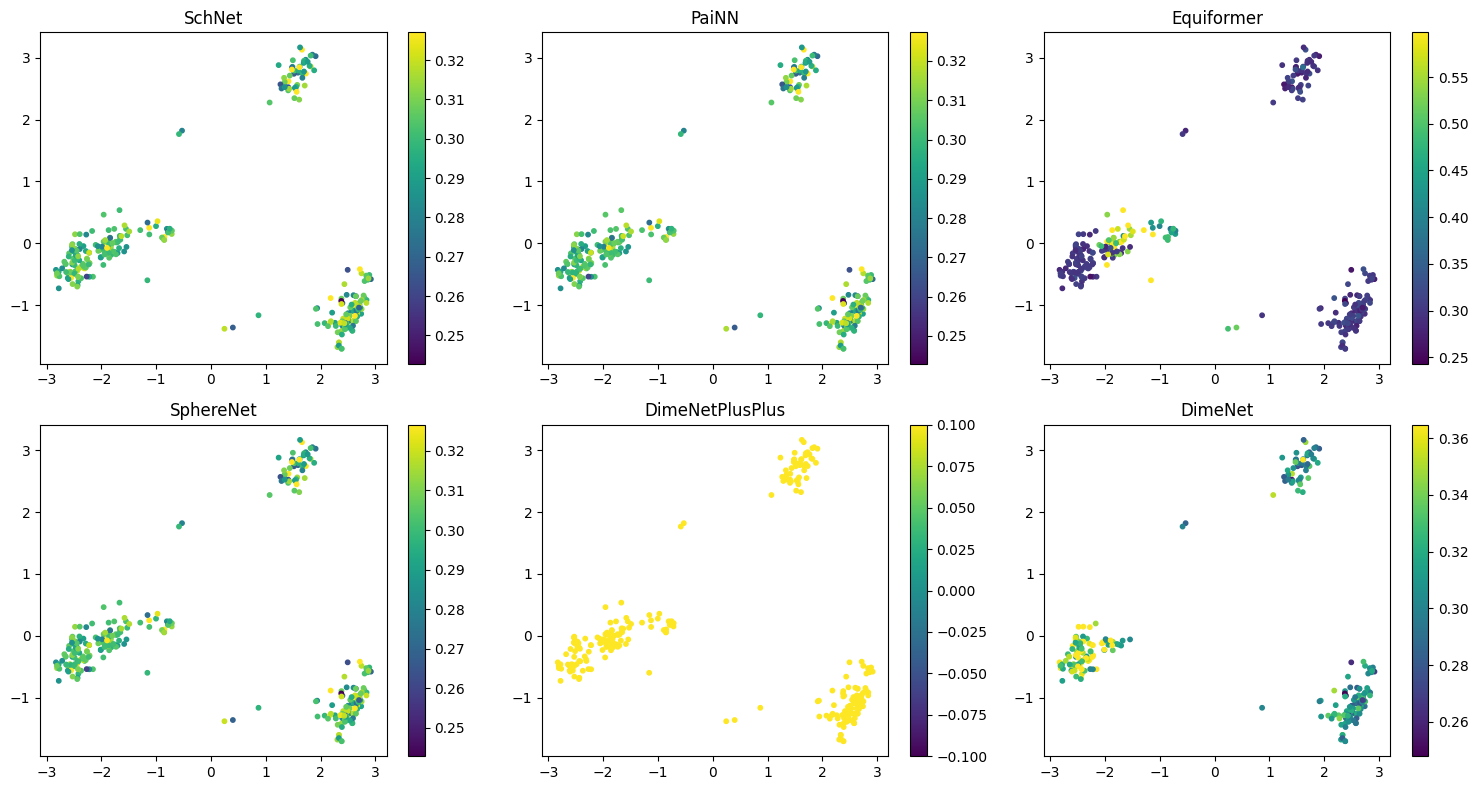

In [30]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Assuming you have a list of model names
model_names = ['SchNet', 'PaiNN', 'Equiformer', 'SphereNet', 'DimeNetPlusPlus', 'DimeNet']  # Update with your actual model names
# model_names = ['DimeNetPlusPlus', 'DimeNet']  # Update with your actual model names

# Assuming you have a list of cluster numbers
cluster_numbers = [1, 2, 3, 4, 5, 6]  # Update with your actual cluster numbers

target = 'ES1'
morgan_fingerprints = np.array(morgan_keys_1['Morgan_Fingerprint'].to_list())

# Apply PCA to reduce dimensionality to 3 components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(morgan_fingerprints)

pca3 = PCA(n_components=3)
pca_result3 = pca3.fit_transform(morgan_fingerprints)

# Create D scatter plot with the PCA results, and color the points by the mean_diff_{model}_ES1
# create different scatter plots for each model

# list of different cmap options: https://matplotlib.org/stable/tutorials/colors/colormaps.html

num_models = len(model_names)
num_cols = num_models // 2 + num_models % 2  # Calculate the number of columns needed
fig, axs = plt.subplots(2, num_cols, figsize=(15, 8))  # Adjust figsize as needed

for i, model_name in enumerate(model_names):
    row = i // num_cols
    col = i % num_cols
    
    # Calculate the 5th and 95th percentiles of the mean differences for the current model
    min_val = np.percentile(morgan_keys[f'mean_diff_{model_name}_{target}'], 0)
    max_val = np.percentile(morgan_keys[f'mean_diff_{model_name}_{target}'], 95)
    
    # Create a scatter plot
    scatter = axs[row, col].scatter(pca_result[:, 0], pca_result[:, 1], c=morgan_keys[f'mean_diff_{model_name}_{target}'], cmap='viridis', s=10, alpha=1, vmin=min_val, vmax=max_val)
    
    # # Set NaN values to grey
    # cmap = plt.cm.get_cmap('summer')
    # cmap.set_bad(color='grey')
    
    # Add a color bar with adjusted limits
    cbar = plt.colorbar(scatter, ax=axs[row, col])
    cbar.ax.tick_params(labelsize=10)

    # Set the title
    axs[row, col].set_title(model_name)

plt.tight_layout()  # Adjust subplot parameters to give specified padding
plt.show()



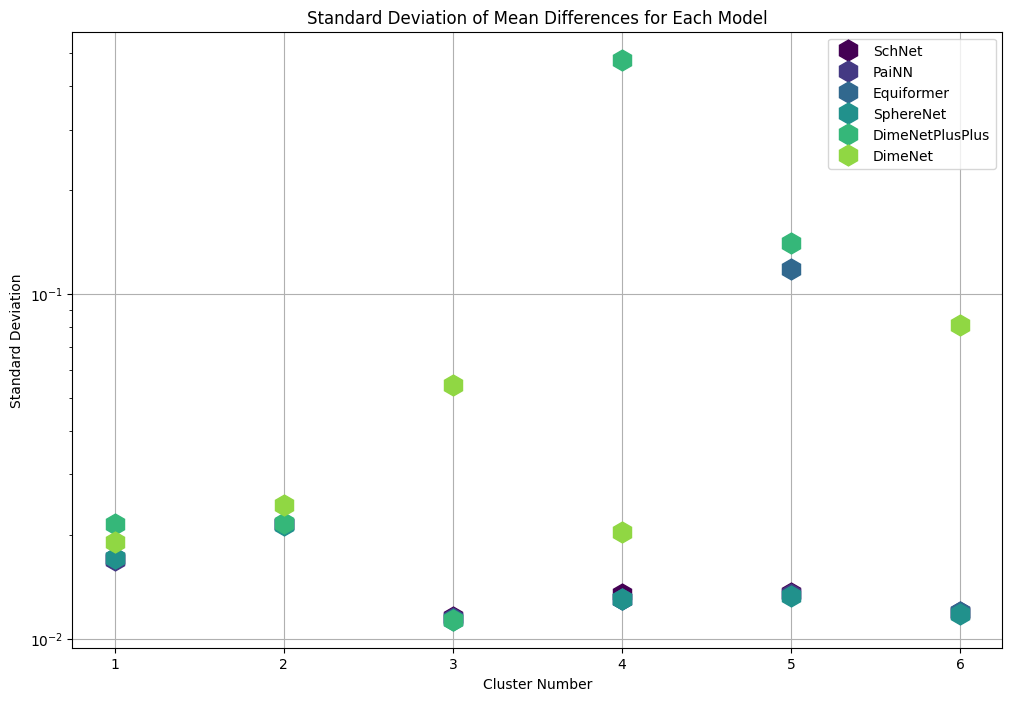

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.cm import viridis

# Assuming you have a list of model names
model_names = ['SchNet', 'PaiNN', 'Equiformer', 'SphereNet', 'DimeNetPlusPlus', 'DimeNet'] # Update with your actual model names

# Assuming you have a list of cluster numbers
cluster_numbers = [1, 2, 3, 4, 5, 6]  # Update with your actual cluster numbers

target = 'ES1'

# Load the morgan_keys dataframe
morgan_keys = pd.read_csv('/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment/fragment_exp_results.csv', index_col=0)

# Initialize a dictionary to store the standard deviations for each model and cluster
std_devs = {}

# Loop over model names
for model_name in model_names:
    # Initialize an empty list to store standard deviations for the current model
    std_devs[model_name] = []
    
    # Loop over cluster numbers
    for cluster in cluster_numbers:
        # Find the rows in the morgan_keys dataframe that correspond to the current cluster
        cluster_df = morgan_keys[morgan_keys['Cluster'] == cluster]
        
        # Calculate the standard deviation for the current model and cluster
        std_dev = cluster_df[f'mean_diff_{model_name}_{target}'].std()
        
        # Append the standard deviation to the list
        std_devs[model_name].append(std_dev)

# Create a figure
plt.figure(figsize=(12, 8))

# Get the number of models
num_models = len(model_names)

# Define the colormap
colormap = viridis

# Loop over model names
for i, model_name in enumerate(model_names):
    # Calculate the color for the current model
    color = colormap(i / num_models)
    # types of markers: https://matplotlib.org/stable/api/markers_api.html
    # types of l
    # Plot the standard deviations for the current model
    plt.plot(cluster_numbers, std_devs[model_name], marker='h', label=model_name, color=color, linestyle='', markersize=15)

# Add labels and title
plt.xlabel('Cluster Number')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation of Mean Differences for Each Model')
plt.legend()
plt.grid(True)
plt.yscale('log')  # Set y-scale to logarithmic

plt.show()


/var/tmp/pbs.9001571.pbs/ipykernel_869429/3867012733.py:35: RuntimeWarning: Mean of empty slice
  mean_diff = np.nanmean(cluster_morgan_keys[f'mean_diff_{model_name}_{target}'])
/var/tmp/pbs.9001571.pbs/ipykernel_869429/3867012733.py:35: RuntimeWarning: Mean of empty slice
  mean_diff = np.nanmean(cluster_morgan_keys[f'mean_diff_{model_name}_{target}'])


['Cluster 1: 31980 oligomers, 99 fragments', 'Cluster 2: 32097 oligomers, 51 fragments', 'Cluster 3: 30696 oligomers, 36 fragments', 'Cluster 4: 38866 oligomers, 30 fragments', 'Cluster 5: 62949 oligomers, 60 fragments', 'Cluster 6: 40684 oligomers, 34 fragments']


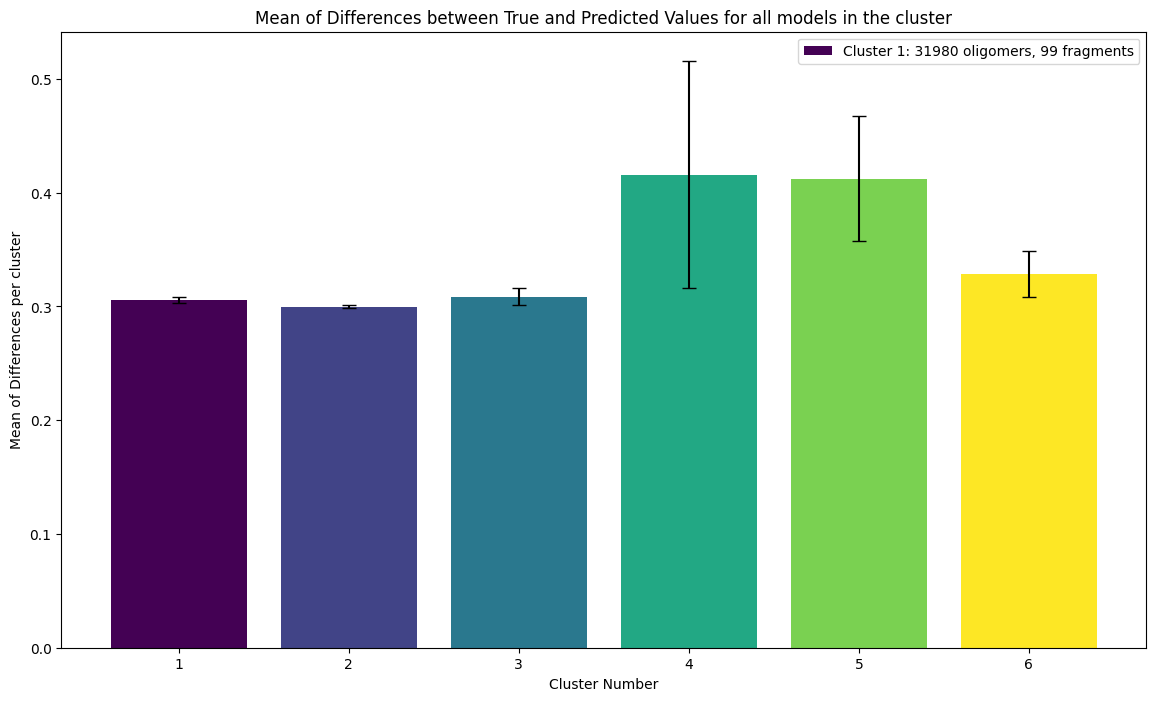

In [77]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.cm import viridis
import os

# Assuming you have a list of model names
model_names = ['SchNet', 'PaiNN', 'Equiformer', 'SphereNet', 'DimeNetPlusPlus', 'DimeNet']  # Update with your actual model names
cluster_numbers = [1, 2, 3, 4, 5, 6]  # Update with your actual cluster numbers
target = 'ES1'

# Load the morgan_keys dataframe
morgan_keys = pd.read_csv('/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment/fragment_exp_results.csv', index_col=0)

# Initialize lists to store means and standard errors for each cluster
means = []
std_errors = []
length = []
length_frag = []

# Create a colormap
colors = viridis(np.linspace(0, 1, len(cluster_numbers)))

# Loop over cluster numbers
for cluster in cluster_numbers:
    # Filter morgan_keys DataFrame by the current cluster
    cluster_morgan_keys = morgan_keys[morgan_keys['Cluster'] == cluster]
    
    # Initialize an empty list to store the means for the current cluster
    cluster_mean_diffs = []
    
    # Loop over model names
    for model_name in model_names:
        # Calculate the mean of the mean_diff_{model}_ES1 column for the current cluster
        mean_diff = np.nanmean(cluster_morgan_keys[f'mean_diff_{model_name}_{target}'])
        
        # Append the mean to the list
        cluster_mean_diffs.append(mean_diff)
    
    # Calculate the mean and standard error for the current cluster
    cluster_mean = np.nanmean(cluster_mean_diffs)
    cluster_std_error = np.nanstd(cluster_mean_diffs) / np.sqrt(len(cluster_mean_diffs))
    
    # Append to the lists
    means.append(cluster_mean)
    std_errors.append(cluster_std_error)

    # load the csv file for the cluster
    csv_path = f'/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment/{cluster}_cluster_{target}_model_inferences.csv'
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path, index_col=0)

    # add the length of the cluster to the length list for each cluster
    length.append(len(df))

    # print how many fragments are in each cluster by looking at morgan_keys dataframe
    length_frag.append(len(cluster_morgan_keys))

# Create a bar plot with error bars
plt.figure(figsize=(14, 8))
plt.bar(cluster_numbers, means, yerr=std_errors, capsize=5, color=colors)

# Add labels and title
plt.xlabel('Cluster Number')
plt.ylabel('Mean of Differences per cluster')
plt.title('Mean of Differences between True and Predicted Values for all models in the cluster')

# Add legend with annotations for the number of oligomers and fragments in each cluster
legend = [f'Cluster {cluster}: {length[i]} oligomers, {length_frag[i]} fragments' for i, cluster in enumerate(cluster_numbers)]
print(legend)

# Add the legend for each cluster
plt.legend(legend, loc = 'upper right')

plt.show()


plt.show()
